In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time
import os
import pickle
import json
import timeit
import datetime
from copy import deepcopy as copy

In [2]:
import torch
from torch.nn import functional as F
torch.cuda.empty_cache()
DTYPE = torch.float32
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [3]:
import sys
sys.path.append('../../')

In [4]:
import IPS_surrogate_util as util

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

cav_type_name = 'QWR041' 

In [6]:
WuLEVEL = 8
TEST = False

BATCH_SIZE = 2**13 #8192
LR = '1E-4'
DROPOUT = False

validation_split = 0.3
hidden_nodes = [128,64,64,64,64]
linear_nodes = 256
activation = torch.nn.ELU()

lr_scheduler = {'final_div_factor':1e3}

In [7]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

QWR041
  W_u_range              [450000.0, 3500000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.24
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR085
  W_u_range              [1000000.0, 33000000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.32
  qA_range               [0.1, 0.6]
  nLEVEL                 16
QWR029
  W_u_range              [12000000.0, 75000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.33
  qA_range               [0.2, 0.6]
  nLEVEL                 4
QWR053
  W_u_range              [35000000.0, 320000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.49
  qA_range               [0.2, 0.6]
  nLEVEL                 4
MGB
  W_u_range              [10000000.0, 30000000.0]
  field_amplitude_range  [0.0, 8.5]
  cav_length             1.2
  qA_range               [0.2, 0.6]
  nLEVEL                 4


In [8]:
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [9]:
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL
W_u_min = W_u_range[0] +WuLEVEL*dW_LEVEL 
W_u_max = W_u_range[0] +WuLEVEL*dW_LEVEL + 1.0*dW_LEVEL

In [10]:
DATA_PATH = "./data/"
MODEL_PATH = "./WuLEVEL"+str(WuLEVEL)#+"_batchsize"+str(BATCH_SIZE)+"_lr"+LR+'_'+'dtype'+str(DTYPE)[-2:]
if DTYPE == torch.float64:
    MODEL_PATH += '_dtype'+str(DTYPE)[-2:]
MODEL_PATH += '/'
LR = float(LR)
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
EPOCHs = 6000  # may increase later... 
if TEST:
    EPOCHs = 100 #int(0.01*EPOCHs)

In [12]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)
def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

# Read data of selected Wu level

In [13]:
fname = os.path.join(DATA_PATH,cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
# fname = os.path.join('./',cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
df = pd.DataFrame(pickle.load(open(fname,'rb')))
df.columns

Index(['phase', 'W/u in', 'Cav amplitude in', 'qA', 'dTau', 'dW_u'], dtype='object')

### construct minmax scalar

In [14]:
Y_LABELs = ['dTau', 'dW_u']
y = df[Y_LABELs].values

Y_MIN = y.min(axis=0) #util.format_floats(y.min(axis=0),num_digits=4)
Y_MAX = y.max(axis=0) #util.format_floats(y.max(axis=0),num_digits=4)
print("Y_LABELs",Y_LABELs)
print("Y_MIN",Y_MIN)
print("Y_MAX",Y_MAX)
print("y.shape",y.shape)

Y_LABELs ['dTau', 'dW_u']
Y_MIN [-5.42414095e-01 -5.19858383e+05]
Y_MAX [3.25358206e-01 4.83133324e+05]
y.shape (134217728, 2)


In [15]:
X_LABELs = ['phase', 'W/u in', 'Cav amplitude in', 'qA']
x = df[X_LABELs].values

X_MIN = [ 0,W_u_min,                       0, qA_range[0]]
X_MAX = [ 1,W_u_max,field_amplitude_range[1], qA_range[1]] 

print("X_LABELs",X_LABELs)
print("X_MIN",X_MIN)
print("X_MAX",X_MAX)

X_LABELs ['phase', 'W/u in', 'Cav amplitude in', 'qA']
X_MIN [0, 1975000.0, 0, 0.1]
X_MAX [1, 2165625.0, 6.0, 0.6]


In [16]:
normalization_info = {'xmin':X_MIN,'xmax':X_MAX,
                      'ymin':Y_MIN,'ymax':Y_MAX,
                      'fname':MODEL_PATH+'scalar_info.pkl'}
scalar = util.scalar(**normalization_info)

### apply normalization

In [17]:
# p = np.random.permutation(len(x))
# x = x[p]
# y = y[p]

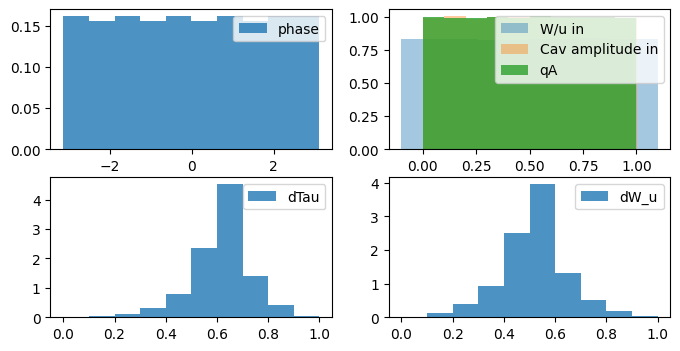

In [18]:
xn = scalar.normalize_x(x)
yn = scalar.normalize_y(y)
fig,ax = plt.subplots(2,2,figsize=(8,4))
ax[0,0].hist(xn[:,0],alpha=0.8,density=True,label=X_LABELs[0]);
ax[0,0].legend()
ax[0,1].hist(xn[:,1],alpha=0.4,density=True,label=X_LABELs[1]);
ax[0,1].hist(xn[:,2],alpha=0.4,density=True,label=X_LABELs[2]);
ax[0,1].hist(xn[:,3],alpha=0.8,density=True,label=X_LABELs[3]);
ax[0,1].legend()
ax[1,0].hist(yn[:,0],alpha=0.8,density=True,label=Y_LABELs[0]);
ax[1,0].legend()
ax[1,1].hist(yn[:,1],alpha=0.8,density=True,label=Y_LABELs[1]);
ax[1,1].legend()

# Train 

In [19]:
model, model_info = util.construct_model(
                                        input_dim  = xn.shape[1],
                                        output_dim  = yn.shape[1],
                                        input_phase_feature_dim = 1,        
                                        linear_nodes = linear_nodes,
                                        hidden_nodes = hidden_nodes,
                                        activation = activation)
model.to(DEVICE).to(DTYPE);

In [20]:
p = model.parameters().__next__()
p.dtype, p.device

(torch.float32, device(type='cuda', index=0))

In [21]:
json.dump(model_info,open(MODEL_PATH+'model_info.json','w'))
model_info

{'input_dim': 4,
 'output_dim': 2,
 'input_phase_feature_dim': 1,
 'linear_nodes': [256],
 'hidden_nodes': [128, 64, 64, 64, 64],
 'activation': 'ELU'}

In [22]:
torch.nn.MSELoss.__name__

'MSELoss'

In [23]:
train_info = {
    'epochs':EPOCHs,
    'lr':LR,
    'batch_size':BATCH_SIZE,
    'criterion': torch.nn.MSELoss.__name__,
    'optimizer': torch.optim.Adam.__name__,
    'optim_args': None,
    'lr_scheduler': lr_scheduler,
    'dropout_stabilization': DROPOUT,
    'shuffle':True,
    'load_best':True,
    'validation_split':validation_split,
    'fname_model'  : MODEL_PATH + 'model.pt',
    'fname_opt'    : MODEL_PATH + 'optimizer.pt',
    'fname_history': MODEL_PATH + 'train_history.pkl'\
}

In [ ]:
history,model_state_dict,opt_state_dict = util.train(
    model,xn,yn,
    **train_info,
    verbose = True,
    )

Train Function Arguments: 2024-04-02 13:03
  - model: _ModelWithPhaseInput
  - x: (134217728, 4)
  - y: (134217728, 2)
  - epochs: 6000
  - lr: 0.0001
  - batch_size: 8192
  - shuffle: True
  - validation_split: 0.3
  - criterion: MSELoss
  - optimizer: Adam
  - optim_args: None
  - optimizer_state_dict: None
  - lr_scheduler: {'final_div_factor': 1000.0}
  - dropout_stabilization: False
  - prev_history: None
  - load_best: True
  - training_timeout: inf
  - verbose: True
  - fname_model: ./WuLEVEL8/model.pt
  - fname_opt: ./WuLEVEL8/optimizer.pt
  - fname_history: ./WuLEVEL8/train_history.pkl

Model Paramers:
  - name: linear_base.0.weight, shape: torch.Size([256, 5]), dtype: torch.float32, device: cuda:0
  - name: linear_base.0.bias, shape: torch.Size([256]), dtype: torch.float32, device: cuda:0
  - name: linear_base.1.weight, shape: torch.Size([2, 256]), dtype: torch.float32, device: cuda:0
  - name: linear_base.1.bias, shape: torch.Size([2]), dtype: torch.float32, device: cuda:0
 

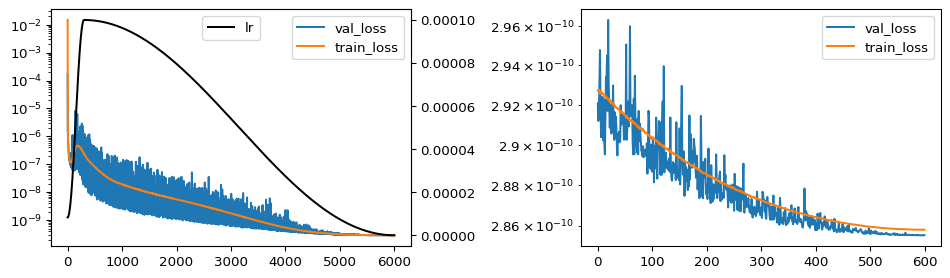

In [39]:
fig,ax=plt.subplots(1,2,figsize=(10,3),dpi=96)
ax[0].semilogy(history['val_loss'],label='val_loss')
ax[0].semilogy(history['train_loss'],label='train_loss')
ax[0].legend()
axx = ax[0].twinx()
axx.plot(history['lr'],label='lr',color='k')
axx.legend(loc='upper center')

ax[1].semilogy(history['val_loss'][-int(0.1*EPOCHs):],label='val_loss')
ax[1].semilogy(history['train_loss'][-int(0.1*EPOCHs):],label='train_loss')
ax[1].legend()
fig.tight_layout()

In [40]:
np.min(history['train_loss']), np.min(history['val_loss'])

(2.857939050125521e-10, 2.8552004091355304e-10)

# loaded model test, w jit, 

In [41]:
model_info = json.load(open(MODEL_PATH + 'model_info.json','r'))
scalar = util.scalar(fname=MODEL_PATH + 'scalar_info.pkl')

### model time cost

##### w/o JIT

In [42]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
model.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
model.eval();

In [43]:
test_x = torch.tensor(xn[:1,:],dtype=DTYPE)

def test():
    model(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 131.1268380470574 micro-sec


##### w JIT

In [44]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
my_script_module = torch.jit.script(model)
my_script_module.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
my_script_module.eval();

In [45]:
def test():
    my_script_module(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 92.7782934717834 micro-sec


# validation

In [46]:
nval = int(validation_split*len(x))
xval = xn[:nval]
yval = yn[:nval]
yval_true_phys = y[:nval]

xval.shape, yval.shape, yval_true_phys.shape

((40265318, 4), (40265318, 2), (40265318, 2))

In [47]:
BATCH_SIZE, nval, len(x)

(8192, 40265318, 134217728)

In [48]:
nbatch = int(len(xval)/BATCH_SIZE)
yval_pred = []
for i in range(nbatch):
    i1 = i*BATCH_SIZE
    i2 = i1+BATCH_SIZE
    x_ = torch.tensor(xval[i1:i2,:],dtype=DTYPE)
    with torch.no_grad():
        yval_pred.append( my_script_module(x_).cpu().numpy() )
        
x_ = torch.tensor(xval[i2:,:],dtype=DTYPE)
with torch.no_grad():
    yval_pred.append( my_script_module(x_).cpu().numpy() )
    
yval_pred_phys = scalar.unnormalize_y(np.concatenate(yval_pred,axis=0))

In [49]:
yval_pred_phys.shape, yval_true_phys.shape

((40265318, 2), (40265318, 2))

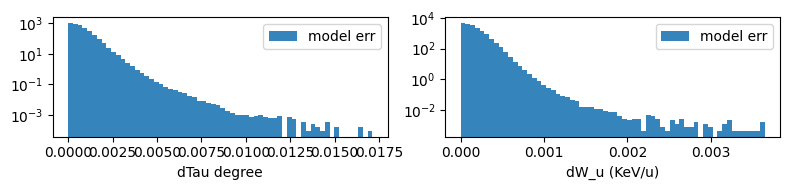

In [50]:
diff_model = np.abs(yval_pred_phys-yval_true_phys)

fig,ax = plt.subplots(1,2,figsize=(8,2))
ax[0].hist(diff_model[:,0]/np.pi*180,bins=64,label='model err',alpha=0.9,density=True)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(Y_LABELs[0]+" degree")

ax[1].hist(diff_model[:,1]*1e-5,bins=64,label='model err',alpha=0.9,density=True)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel(Y_LABELs[1]+" (KeV/u)")

fig.tight_layout()
fig.savefig(MODEL_PATH+'plot_validation.png',dpi=64)